### Objectives

Build a probabilistic model to predict customer lifetime value for non-contractual business 

* Find out who are most likely to buy again 
* Estimate Customer Lifetime Value
* Calculate expected average profit per customer 

### Data Scource
Brazilian E-Commerce Public Dataset by Olist 
<br /> 100,000 Orders with product, customer and reviews info
<br /> https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv

### Frequency & Recency Analysis using BG/NBD Model

#### BG/NBD Model 5 Assumptions:
1. While active, the number of transactions made by a customer follows a Poisson process with transaction rate . This is equivalent to assuming that the time between transactions is distributed exponential with transaction rate λ
2. Heterogeneity in  follows a gamma distribution with pdf
3. After any transaction, a customer becomes inactive with probability p. Therefore, the point at which the customer “drops out” is distributed across transactions according to a (shifted) geometric distribution with pmf P inactive immediately after jth transaction
4. Heterogeneity in p follows a beta distribution with pdf
5. The transaction rate and the dropout probability p vary independently across customers

#### The following nomenclature is used:

**Frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

**T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

**Recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

**Monetary** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.



### Import Packages and Data Processing 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

In [2]:
customers_raw = pd.read_csv("../input/brazilian-ecommerce/olist_customers_dataset.csv")
orders_raw = pd.read_csv("../input/brazilian-ecommerce/olist_orders_dataset.csv", parse_dates = ['order_purchase_timestamp'])
orderItems_raw = pd.read_csv("../input/brazilian-ecommerce/olist_order_items_dataset.csv")

In [3]:
# Check the structure of the data
customers_raw.info()
# Inspect the data
customers_raw.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


In [4]:
customers = customers_raw[['customer_id', 'customer_unique_id']]
customers.head()

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066


In [5]:
# Check the structure of the data
orders_raw.info()
# Inspect the data
orders_raw.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522
first,NaN,NaN,NaN,2016-09-04 21:15:19,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-10-17 17:30:18,NaN,NaN,NaN,NaN


Filter orders by order_status. Here we will exclude orders with 'canceled' as order_status. We have to consider fraud in real live situation. Since we don't have much information about the status in this dataset, we are going to be inclusive about the orders. 

We will use order_purchase_timestamp as date

In [6]:
orders_raw['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [7]:
orders_raw = orders_raw[orders_raw.order_status != 'canceled']
orders_raw['date'] = pd.to_datetime(orders_raw['order_purchase_timestamp']).dt.date

In [8]:
orders = orders_raw[['order_id', 'customer_id','date']]
orders.head()

,order_id,customer_id,date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13


In [9]:
orderItems_raw.info()
orderItems_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [10]:
orderItems_raw['order_id'].nunique()

98666

In [11]:
orderTrans = orderItems_raw.groupby(['order_id']).agg({'price':'sum'}).reset_index()
orderTrans.rename(columns={'price':'revenue'}, inplace = True)
orderTrans

,order_id,revenue
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


Combine Orders dataset with OrderItems dataset to get the revenue of each orders 

In [12]:
orderDetails = pd.merge(orders, orderTrans, on = 'order_id', how = 'left')
orderDetails

,order_id,customer_id,date,revenue
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13,19.90
...,...,...,...,...
98811,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09,72.00
98812,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06,174.90
98813,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27,205.99
98814,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08,359.98


In [13]:
orderCusDetails_raw = pd.merge(customers, orderDetails, on = 'customer_id', how = 'left')
orderCusDetails_raw

,customer_id,customer_unique_id,order_id,date,revenue
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,230.00
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07,74.90
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04,114.90
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08,37.00
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03,689.00


In [14]:
# Testing
orderCusDetails_raw[orderCusDetails_raw['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']

,customer_id,customer_unique_id,order_id,date,revenue
28432,6152d0774bbbf74f7140541c0569dafa,12f5d6e1cbf93dafd9dcc19095df0b3d,9b91ddcbd6cbceb83d4fd2462ca1f95e,2017-01-05,10.9
35693,588047d7101d88c333691e47659d7099,12f5d6e1cbf93dafd9dcc19095df0b3d,ca5a215980675471f0cf8199c041909a,2017-01-05,10.9
71569,c0352e94059e3e5a714c9ad0c8306a54,12f5d6e1cbf93dafd9dcc19095df0b3d,17fed53ba6dfef9b594ee2268642e2aa,2017-01-05,9.9
89230,27129ce1ebca4ffa23a049c51cc8ec95,12f5d6e1cbf93dafd9dcc19095df0b3d,464de32dc84484c1d26df3e8e38e708b,2017-01-05,6.9
97034,ed1793d2d1e4175d5846ce7ebb4a01f5,12f5d6e1cbf93dafd9dcc19095df0b3d,747996a66f5aa711deb8ae58f5ae46a0,2017-01-05,9.9
98493,a969b9f8d923bc7fd97b578f7c499194,12f5d6e1cbf93dafd9dcc19095df0b3d,8a784d47854e4cbc5562362393d504db,2017-01-05,9.9


In [15]:
orderCusDetails = orderCusDetails_raw.groupby(['customer_unique_id','date']).agg({'revenue':'sum'}).reset_index()
orderCusDetails

,customer_unique_id,date,revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,180.00
...,...,...,...
97872,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,1570.00
97873,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,64.89
97874,ffff371b4d645b6ecea244b27531430a,2017-02-07,89.90
97875,ffff5962728ec6157033ef9805bacc48,2018-05-02,115.00


In [16]:
# Testing
orderCusDetails[orderCusDetails['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']

,customer_unique_id,date,revenue
7299,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05,58.4


In [17]:
orderCusDetails['customer_unique_id'].nunique()

95560

In [18]:
df = orderCusDetails.copy()

In [19]:
print('Min : {}, Max : {}'.format(min(df['date']), max(df['date'])))
lastDate = max(df['date']) + dt.timedelta(1)
print(lastDate)

Min : 2016-09-04, Max : 2018-09-03
2018-09-04


In [20]:
df1 = df.groupby('customer_unique_id') .agg({'date': lambda x:(lastDate - x.min()).days}).reset_index()
df1.rename(columns = {'date':'T'}, inplace = True)
df1

,customer_unique_id,T
0,0000366f3b9a7992bf8c76cfdf3221e2,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120
2,0000f46a3911fa3c0805444483337064,543
3,0000f6ccb0745a6a4b88665a16c9f078,327
4,0004aac84e0df4da2b147fca70cf8255,294
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,453
95556,fffea47cd6d3cc0a88bd621562a9d061,268
95557,ffff371b4d645b6ecea244b27531430a,574
95558,ffff5962728ec6157033ef9805bacc48,125


In [21]:
df2 = df.groupby('customer_unique_id').agg({'date': lambda x:(x.max() - x.min()).days}).reset_index()
df2.rename(columns = {'date':'recency'}, inplace = True)
df2

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0
2,0000f46a3911fa3c0805444483337064,0
3,0000f6ccb0745a6a4b88665a16c9f078,0
4,0004aac84e0df4da2b147fca70cf8255,0
...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,0
95556,fffea47cd6d3cc0a88bd621562a9d061,0
95557,ffff371b4d645b6ecea244b27531430a,0
95558,ffff5962728ec6157033ef9805bacc48,0


In [22]:
# Testing
# df2[df2['customer_unique_id'] == '12f5d6e1cbf93dafd9dcc19095df0b3d']
df2[df2['recency'] != 0]

,customer_unique_id,recency
106,004288347e5e88a27ded2bb23747066c,171
124,004b45ec5c64187465168251cd1c9c2f,267
248,00a39521eb40f7012db50455bf083460,11
412,011575986092c30523ecb71ff10cb473,60
427,011b4adcd54683b480c4d841250a987f,177
...,...,...
95107,fed519569d16e690df6f89cb99d4e682,88
95175,ff03923ad1eb9e32304deb7f9b2a45c9,33
95223,ff22e30958c13ffe219db7d711e8f564,10
95382,ff8892f7c26aa0446da53d01b18df463,186


In [23]:
df3 = df.groupby(['customer_unique_id']).agg({'date': 'count',                                             
                                             'revenue':'sum'}).reset_index()
df3.rename(columns = {'date':'frequency','revenue':'total_monetary'}, inplace = True)
df3

,customer_unique_id,frequency,total_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90
2,0000f46a3911fa3c0805444483337064,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,180.00
...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,1,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,1,64.89
95557,ffff371b4d645b6ecea244b27531430a,1,89.90
95558,ffff5962728ec6157033ef9805bacc48,1,115.00


In [24]:
df3['avg_monetary'] = df3['total_monetary'] / df3['frequency']
df3['frequency'] = df3['frequency'] - 1
df3 = df3.drop(columns=['total_monetary'])
df3

,customer_unique_id,frequency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,18.90
2,0000f46a3911fa3c0805444483337064,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,0,180.00
...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,0,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,0,64.89
95557,ffff371b4d645b6ecea244b27531430a,0,89.90
95558,ffff5962728ec6157033ef9805bacc48,0,115.00


In [25]:
# Testing
# df3[df3['frequency'] != 0]
df3[df3['customer_unique_id'] == '02168ea18740a0fdaaa15f11bebba5db']

,customer_unique_id,frequency,avg_monetary
779,02168ea18740a0fdaaa15f11bebba5db,1,99.8


In [26]:
df_combined1 = pd.merge(df1, df2, on = 'customer_unique_id', how = 'outer')
df_combined2 = pd.merge(df_combined1, df3, on = 'customer_unique_id', how = 'outer')
df_combined2

,customer_unique_id,T,recency,frequency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,0,0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,0,0,18.90
2,0000f46a3911fa3c0805444483337064,543,0,0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,0,0,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,0,0,180.00
...,...,...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,453,0,0,1570.00
95556,fffea47cd6d3cc0a88bd621562a9d061,268,0,0,64.89
95557,ffff371b4d645b6ecea244b27531430a,574,0,0,89.90
95558,ffff5962728ec6157033ef9805bacc48,125,0,0,115.00


In [27]:
# Testing
orderCusDetails[orderCusDetails['customer_unique_id'] == 'ff922bdd6bafcdf99cb90d7f39cea5b3']

,customer_unique_id,date,revenue
97715,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-02-22,24.90
97716,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-08-23,40.00
97717,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-09-14,29.89


In [28]:
# Testing
df_combined2[df_combined2['recency'] != 0]

,customer_unique_id,T,recency,frequency,avg_monetary
106,004288347e5e88a27ded2bb23747066c,404,171,1,158.945000
124,004b45ec5c64187465168251cd1c9c2f,368,267,1,43.450000
248,00a39521eb40f7012db50455bf083460,104,11,1,40.725000
412,011575986092c30523ecb71ff10cb473,199,60,1,91.450000
427,011b4adcd54683b480c4d841250a987f,378,177,1,91.715000
...,...,...,...,...,...
95107,fed519569d16e690df6f89cb99d4e682,258,88,1,124.950000
95175,ff03923ad1eb9e32304deb7f9b2a45c9,134,33,1,110.320000
95223,ff22e30958c13ffe219db7d711e8f564,11,10,1,145.000000
95382,ff8892f7c26aa0446da53d01b18df463,468,186,1,138.975000


### Basic Frequency/Recency Analysis

In [29]:
pip install lifetimes 

     |████████████████████████████████| 584 kB 4.2 MB/s 
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=4a1b00a1110b0687e9a96fd706012ba133fe28c247fce2720063848ba3c9ec69
  Stored in directory: /root/.cache/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd
Note: you may need to restart the kernel to use updated packages.


In [30]:
import lifetimes

In [31]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef = 0.001)
bgf.fit(df_combined2['frequency'], df_combined2['recency'], df_combined2['T'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 95560 subjects, a: 0.36, alpha: 70.85, b: 0.06, r: 0.02>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.016181,0.000882,0.014451,0.017911
alpha,70.851985,6.866974,57.392717,84.311254
a,0.356730,0.048714,0.261250,0.452209
b,0.060021,0.009602,0.041202,0.078841


### Visualizing Frequency/Recency Matrix

which computes the expected number of transactions an artificial customer is to make in the next time period, given his or her recency and frequency. 

#### Expected Number of Future Purchases for 1 Unit of Time

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

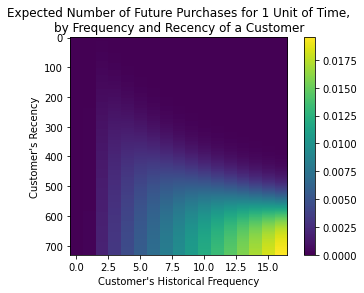

In [32]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 15 times from us, and their latest purchase was when they were 700 days old, then they are our best customer (bottom-right).

Area around (4,350) - Customers who buy infrequently, but we've seem them recently. They might be dead or just between purchases

#### Probability of Still Being Alive

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

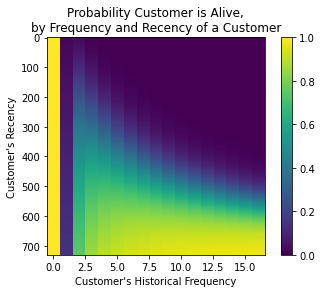

In [33]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

#### Customers Who Will Most Lilely to Buy Again

In [34]:
t = 1
df_combined2['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_combined2['frequency'], df_combined2['recency'], df_combined2['T'])
df_combined2.sort_values(by='predicted_purchases', ascending=False).head()

,customer_unique_id,T,recency,frequency,avg_monetary,predicted_purchases
52676,8d50f5eadf50201ccdcedfb9e2ac8455,477,462,16,42.918824,0.028183
75650,ca77025e7201e3b30c44b472ff346268,330,235,6,115.230000,0.011040
21458,394ac4de8f3acb14253c177f0e15bc58,256,236,4,126.632000,0.010676
83899,e0836a97eaae86ac4adc26fbb334a527,70,62,2,20.993333,0.010366
37598,6469f99c1f9dfae7733b25662e7f1782,350,282,5,110.700000,0.009824


These are the customers who are probably going to buy again in the next period. 

#### Assessing Model Fit

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

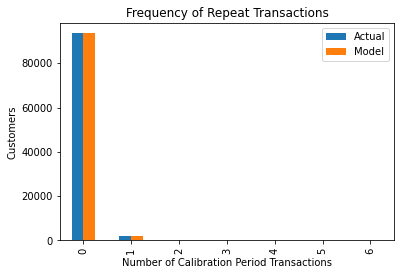

In [35]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

Actual data and simulated data are mostly the same 

#### Predicting Customer's Future Behavior

In [36]:
t = 100 #predict purchases in 100 days
individual = df_combined2.iloc[66666]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.010457172814431762

### Estimating Customer Lifetime Value Using the Gamma-Gamma Model

This model assumes that there is no relationship between the monetary value and the purchase frequency. 
In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [37]:
returning_customers_summary = df_combined2[(df_combined2['frequency'] > 0) & (df_combined2['avg_monetary'] > 0)]
returning_customers_summary.head()

,customer_unique_id,T,recency,frequency,avg_monetary,predicted_purchases
106,004288347e5e88a27ded2bb23747066c,404,171,1,158.945,0.000167
124,004b45ec5c64187465168251cd1c9c2f,368,267,1,43.450,0.000264
248,00a39521eb40f7012db50455bf083460,104,11,1,40.725,0.000419
412,011575986092c30523ecb71ff10cb473,199,60,1,91.450,0.000281
427,011b4adcd54683b480c4d841250a987f,378,177,1,91.715,0.000191


In [38]:
returning_customers_summary[['avg_monetary', 'frequency']].corr()

,avg_monetary,frequency
avg_monetary,1.000000,-0.003708
frequency,-0.003708,1.000000


Since the correlation between monetary and frequency is not strong, we can use Gamma-Gamma model to predict the conditional, expected average lifetime value of customers 

In [39]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['avg_monetary'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2090 subjects, p: 3.97, q: 3.59, v: 83.69>


In [40]:
ggf.conditional_expected_average_profit(
         returning_customers_summary['frequency'],
         returning_customers_summary['avg_monetary']).head()

106    146.696572
124     76.868495
248     75.220965
412    105.889212
427    106.049430
dtype: float64

In [41]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        df_combined2['frequency'],
        df_combined2['avg_monetary']
    ).mean(),
    df_combined2[df_combined2['frequency']>0]['avg_monetary'].mean()
))


Expected conditional average profit: 127.97167657062245, Average profit: 128.21412782923915


#### References:
1. https://lifetimes.readthedocs.io/en/latest/Quickstart.html#estimating-customer-lifetime-value-using-the-gamma-gamma-model
2. “Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Model by Fader et al. in 2005. http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

